In [13]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
-%autoreload 2
from collections import defaultdict
from datetime import datetime
import h5py
from kneed import KneeLocator
import matplotlib.pyplot as plt
from neural_analysis.matIO import loadmat
import numpy as np
import os
import pandas as pd
import re
from scipy.signal import butter, filtfilt, freqz
import sys
import time
from tqdm.auto import tqdm

sys.path.append('../../..')
from ld_utils import compute_eigs, get_data_sigma_norms
from up_down import get_up_down
from utils import compile_folder, get_data_class, get_result_path, load, save, to_string

In [29]:
## propofolPuffTone
# session = 'Mary-Anesthesia-20160809-01'
session = 'MrJones-Anesthesia-20160105-01'
# session = 'MrJones-Anesthesia-20160113-01'

## propofolWakeup
# session = 'Mary-Anesthesia-20170203-02'

## Load Neural Data

In [30]:
all_data_dir = f"/om/user/eisenaj/datasets/anesthesia/mat"
data_class = get_data_class(session, all_data_dir)

In [31]:
filename = os.path.join(all_data_dir, data_class, f'{session}.mat')
print("Loading data ...")
start = time.process_time()
electrode_info, lfp, lfp_schema, session_info, spike_times, unit_info = loadmat(filename, variables=['electrodeInfo', 'lfp', 'lfpSchema', 'sessionInfo', 'spikeTimes', 'unitInfo'], verbose=False)
spike_times = spike_times[0]
dt = lfp_schema['smpInterval'][0]
T = lfp.shape[0]

print(f"Data loaded (took {time.process_time() - start:.2f} seconds)")

Loading data ...
Data loaded (took 207.11 seconds)


## Find Prediction Errors (All Window Sizes)

In [ ]:
results_dir = f"/om/user/eisenaj/ChaoticConsciousness/results/{data_class}/VAR"

predictions = {}
true_vals = {}
step_mse = {}
for area in np.unique(electrode_info['area']):
    predictions[area] = {}
    true_vals[area] = {}
    step_mse[area] = {}
predictions['all'] = {}
true_vals['all'] = {}
step_mse['all'] = {}

# windows = [0.5, 1, 1.5, 2, 2.5, 3, 4, 5, 7.5, 10]
windows = [0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5, 5.5, 6, 6.5, 7, 7.5, 8, 8.5, 9, 9.5, 10]
for window in windows:
    stride = window
    print(f"Now computing window = {window}")
    VAR_results_dir = get_result_path(results_dir, session, window, stride)
    VAR_results = {}
    for file in tqdm(os.listdir(VAR_results_dir)):
        try:
            VAR_results[file] = load(os.path.join(VAR_results_dir, file))
        except IsADirectoryError:
            print(f"Need to compile {os.path.join(VAR_results_dir, file)}")
            # compile results
            VAR_results[file] = compile_folder(os.path.join(VAR_results_dir, file))
    
    for area in VAR_results.keys():
        if area == 'all':
            unit_indices = np.arange(len(electrode_info['area']))
        else:
            unit_indices = np.where(electrode_info['area'] == area)[0]
        T_pred = 25
        predictions[area][window] = np.zeros((len(VAR_results[area]), T_pred, len(unit_indices)))
        true_vals[area][window] = np.zeros(predictions[area][window].shape)

        for i in tqdm(range(predictions[area][window].shape[0])):
            row = VAR_results[area].iloc[i]
            start_step = int(stride*i/dt)
            x0 = lfp[start_step + int(window/dt) - 1, unit_indices]

            for t in range(T_pred):
                if t == 0:
                    predictions[area][window][i, t] = np.hstack([[1], x0]) @ row.A_mat_with_bias
                else:
                    predictions[area][window][i, t] = np.hstack([[1], predictions[area][window][i, t - 1]]) @ row.A_mat_with_bias

            true_vals[area][window][i] = lfp[start_step + int(window/dt):start_step + int(window/dt) + T_pred, unit_indices]

        step_mse[area][window] = ((predictions[area][window] - true_vals[area][window])**2).mean(axis=2)

Now computing window = 0.5


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/24889 [00:00<?, ?it/s]

  0%|          | 0/24889 [00:00<?, ?it/s]

In [ ]:
area = 'all'
start_time = 120

In [ ]:
rows = 5
cols = 5
fig, axs = plt.subplots(rows, cols, figsize=(12, 8))

for i in range(T_pred):
    ax = axs[int(i/cols), i % cols]
    ax.plot(windows, [step_mse[area][window][int(start_time/window):, i].mean() for window in windows])
    ax.set_title(f"MSE on {i+1}-Step Prediction")
    ax.set_xlabel("Window Size")
    ax.set_ylabel("MSE")

plt.suptitle("Prediction MSE Across Whole Session")
plt.tight_layout()
plt.show()

In [ ]:

end_anesthesia = session_info['drugEnd'][1]
end_anesthesia = int(end_anesthesia/stride)

rows = 5
cols = 5
fig, axs = plt.subplots(rows, cols, figsize=(12, 8))

for i in range(T_pred):
    ax = axs[int(i/cols), i % cols]
    ax.plot(windows, [step_mse[area][window][int(start_time/window):int(session_info['drugStart'][0]/window), i].mean() for window in windows], label='pre anesthestic')
    ax.plot(windows, [step_mse[area][window][int(session_info['drugStart'][0]/window):int(session_info['drugEnd'][1]/window), i].mean() for window in windows], label='during anesthestic')
    ax.plot(windows, [step_mse[area][window][int(session_info['drugEnd'][1]/window):, i].mean() for window in windows], label='post anesthestic')
    ax.set_title(f"MSE on {i+1}-Step Prediction")
    ax.set_xlabel("Window Size")
    ax.set_ylabel("MSE")

ax.legend()
plt.suptitle("Prediction MSE Split By Segment")
plt.tight_layout()
plt.show()

### Window Size Autoselection

In [ ]:
step_to_use = 10
start_time = 120
improvement_thresh = 0.02 # if the improvement is less than the threshold, pick the previous window
selected_windows = {}
for area in step_mse.keys():
    window_mses = [step_mse[area][window][int(start_time/window):, step_to_use - 1].mean() for window in windows]
    
    kneedle_ret = KneeLocator(windows, window_mses, S=2, curve='convex', direction='decreasing')
    selected_windows[area] = kneedle_ret.elbow
    
#     improvements = np.array([1 - window_mses[i+1]/window_mses[i] for i in range(len(window_mses)-1)])
# #     if area == 'vlPFC':
# #         print(improvements)
#     comparison = improvements < improvement_thresh
#     if np.sum(comparison) == 0:
#         selected_windows[area] = None
#     else:
#         selected_windows[area] = windows[np.argmax(comparison)]

In [ ]:
selected_windows

In [27]:
save(selected_windows, os.path.join(results_dir, f"{session}_selected_windows_{step_to_use}_steps"))

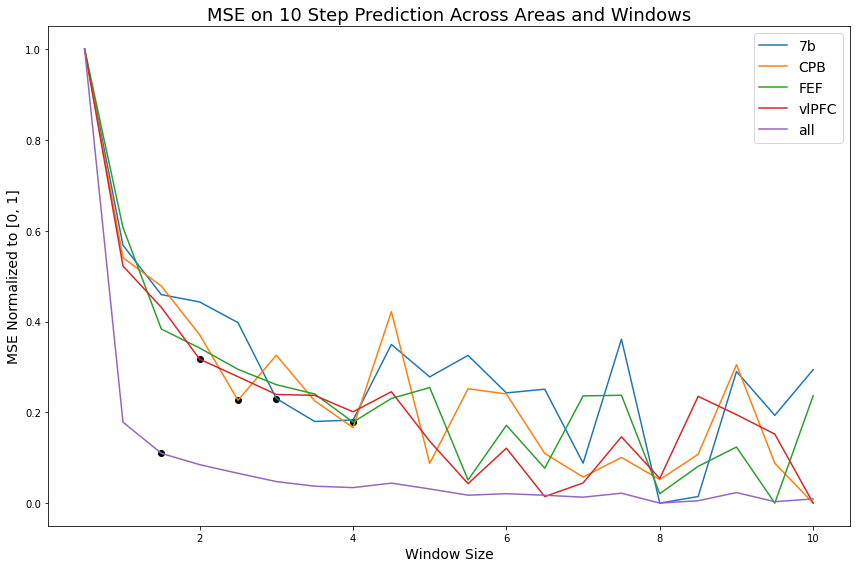

In [28]:
# fig, axs = plt.subplots(3, 2, figsize=(12, 8))
fig = plt.figure(figsize=(12, 8))
ax = plt.gca()
for i, area in enumerate(selected_windows.keys()):
#     ax = axs[int(i/2), i % 2]
    mse_per_window = np.array([step_mse[area][window][int(start_time/window):, step_to_use - 1].mean() for window in windows])
    min_val = mse_per_window.min()
    max_val = mse_per_window.max()
    mse_per_window -= min_val
    mse_per_window /= max_val - min_val
    ax.plot(windows, mse_per_window, label=area)
    pt = step_mse[area][selected_windows[area]][int(start_time/selected_windows[area]):, step_to_use - 1].mean()
    pt -= min_val
    pt /= max_val - min_val
    ax.scatter(selected_windows[area], pt, color='k')
# ax.set_title(f"MSE on {i+1}-Step Prediction")
ax.set_xlabel("Window Size", fontsize=14)
ax.set_ylabel("MSE Normalized to [0, 1]", fontsize=14)
plt.legend(fontsize=14)
plt.title(f"MSE on {step_to_use} Step Prediction Across Areas and Windows", fontsize=18)
    
#     PLOT THE AREA WINDOW SIZE MSES AND A DOT AT THE SELECTED VALUE
plt.tight_layout()

## Find Prediction Errors (One Window Size)

In [48]:
window = 0.15
results_dir = "/om/user/eisenaj/ChaoticConsciousness/results/propofol/VAR"
run_data = get_result(results_dir, session, window)

In [76]:
area = 'all'

unit_indices = run_data['run_params']['unit_indices'][area]
T_pred = 5
predictions = np.zeros((len(run_data['results'][area]), T_pred, len(unit_indices)))
true_vals = np.zeros(predictions.shape)

for i in tqdm(range(predictions.shape[0])):
    row = run_data['results'][area].iloc[i]
    start_step = int(run_data['run_params']['stride']*i/dt)
    x0 = lfp[start_step + int(run_data['run_params']['window']/dt) - 1, unit_indices]

    for t in range(T_pred):
        if t == 0:
            predictions[i, t] = np.concatenate([[1], x0]) @ row.A_mat_with_bias
        else:
            predictions[i, t] = np.concatenate([[1], predictions[i, t - 1]]) @ row.A_mat_with_bias
            
    true_vals[i] = lfp[start_step + int(run_data['run_params']['window']/dt):start_step + int(run_data['run_params']['window']/dt) + T_pred, unit_indices]

step_mse = ((predictions - true_vals)**2).mean(axis=2)

  0%|          | 0/47035 [00:00<?, ?it/s]

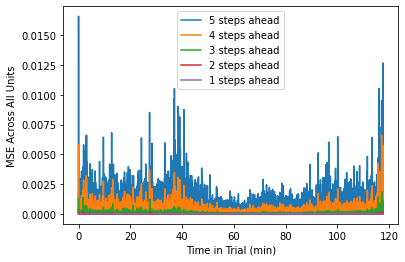

In [103]:
# i = 90
# unit_num = 5
# plt.plot(predictions[i, :, unit_num])
# plt.plot(true_vals[i, :, unit_num])
# plt.show()

time_in_trial = np.arange(step_mse.shape[0])*run_data['run_params']['stride']/60
for t in range(4, -1, -1):
    plt.plot(time_in_trial[1:], step_mse[1:, t], label=f"{t + 1} steps ahead")
plt.legend()
plt.xlabel("Time in Trial (min)")
plt.ylabel("MSE Across All Units")
plt.show()